# dan_bot EDA

Read and process data 

In [2]:
% matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import warnings
import numpy as np
from collections import defaultdict
from operator import itemgetter
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
import keras
import seaborn as sns; sns.set()
import sys
import os
from pathlib import Path

sys.path.insert(0, '../dan_bot')

from dan_bot import utils
from dan_bot.nn_classifier import NnClassifier
from utils import process_pkl, f1, text_to_wordlist, user_id, sentiment_transform, clean_reaction, sub_user, encoder_predict, process_pred_specified_models

warnings.filterwarnings("ignore")


store = {}
emoji_count = defaultdict(int)
clf = NnClassifier()

user_dict = clf.user_dict()
channel_mapping = clf.channel_mapping()

long_data = process_pkl(channel_mapping, user_dict)

long_data['time'] =  pd.to_datetime(long_data['time'],unit='s')
print(long_data.shape)
long_data.tail()

number of msgs loaded:  14931
(9377, 6)


,channel,comment,emoji,time,type,user
9372,pijane_kaczki,sweet !,+1,2016-05-12 12:53:38.000042915,message,steven.perianen
9373,pijane_kaczki,hi < ! here here can we have a quick chat n...,+1,2016-05-12 12:13:36.000035048,message,steven.perianen
9374,devops,tomskopek updating your key as well so that...,joy,2016-05-12 11:52:48.000420094,message,kingori
9375,developers,< ! channel presentaion starting in 1 min,+1,2016-05-12 09:33:59.000010967,message,donovan.thomson
9376,pijane_kaczki,hi team im can we stand up at 9 30 today ple...,ok_hand,2016-05-11 07:44:40.000001907,message,steven.perianen


# Counts of Various Emojis Used

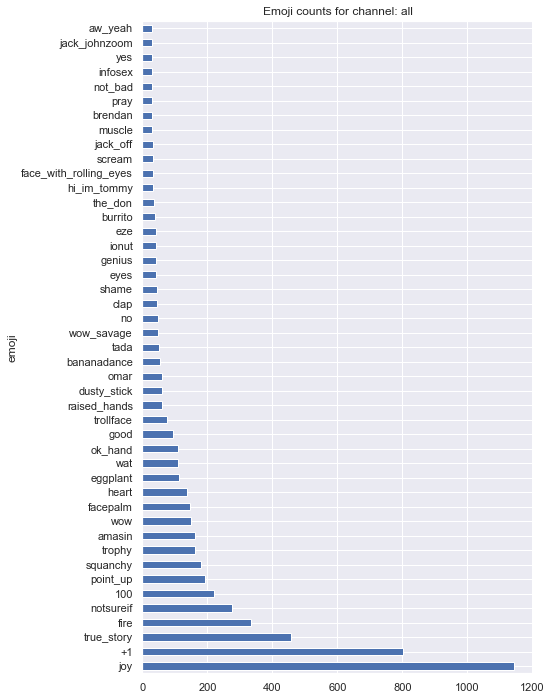

In [3]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

w=widgets.Dropdown(
    options=long_data['channel'].unique().tolist() + ['all'],
    value='all',
    description='Channel:',
    disabled=False,
)

def my_plot(w):
    fig, ax = plt.subplots(figsize=(7, 12))
    tmp = long_data if w == 'all' else long_data[long_data['channel'] == w]
    tmp.groupby('emoji').count()['time'].rename('count').sort_values(ascending=False).head(45).plot(grid=True, ax=ax, kind='barh');
    ax.set_title('Emoji counts for channel: %s' % w);
    plt.show()

# interactive_plot = interactive(my_plot, w=w)
# interactive_plot
my_plot('all')

# Emoji Usage Over Time

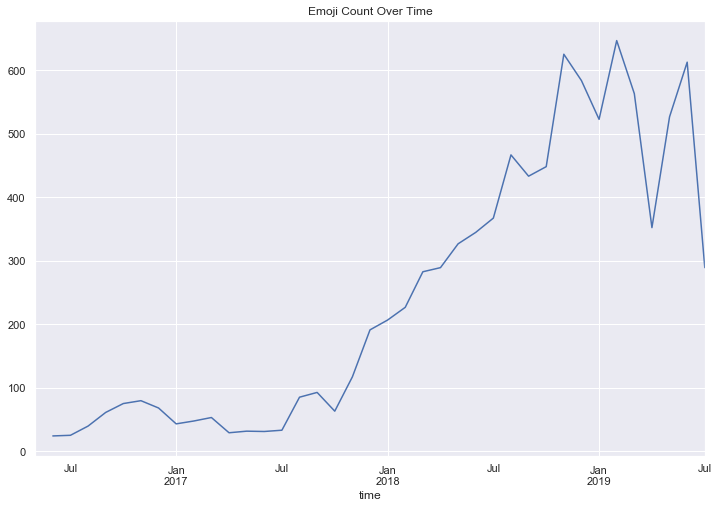

In [4]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

w=widgets.Dropdown(
    options=long_data['emoji'].unique().tolist() + ['all'],
    value='all',
    description='Emoji:',
    disabled=False,
)

def my_plot(w=None):
    fig, ax = plt.subplots(figsize=(12, 8))
    tmp = long_data if w == 'all' else long_data[long_data['emoji'] == w]
    tmp.groupby(pd.Grouper(key='time', freq='M')).count()['emoji'].rolling(2).mean().plot(grid=True, color = 'b');
    ax.set_title('Emoji Count Over Time');
    plt.show()

# interactive_plot = interactive(my_plot, w=w)
# interactive_plot
my_plot('all')

# Filter Emojis

Select emojis that have at least 10 appearences

In [5]:
agg = long_data.groupby('emoji').count()['comment']

emoji_counts = pd.DataFrame(agg.sort_values(ascending=False))
filtered_emojis = emoji_counts[emoji_counts['comment'] > 10].index.tolist()
df = long_data[long_data['emoji'].isin(filtered_emojis + ['elephant', 'no', 'kruskal'])]
print('filering comments with most commonn emojis, down to ', df.shape)
emoji_counts.head(20)

filering comments with most commonn emojis, down to  (7267, 6)


,comment
emoji,
joy,1145
+1,801
true_story,458
fire,335
notsureif,275
100,219
point_up,194
squanchy,181
trophy,162


## Huge sample inbalance in emojis

Try downsample `joy` for now

###TODO maybe do it for +1 also.. keras class weights function should work though

In [6]:
ind = df[df['emoji'] == 'joy'].index[:500]
df = df[~df.index.isin(ind)]
print('new shape: ', df.shape)

new shape:  (6767, 6)


## Emoji usage over time

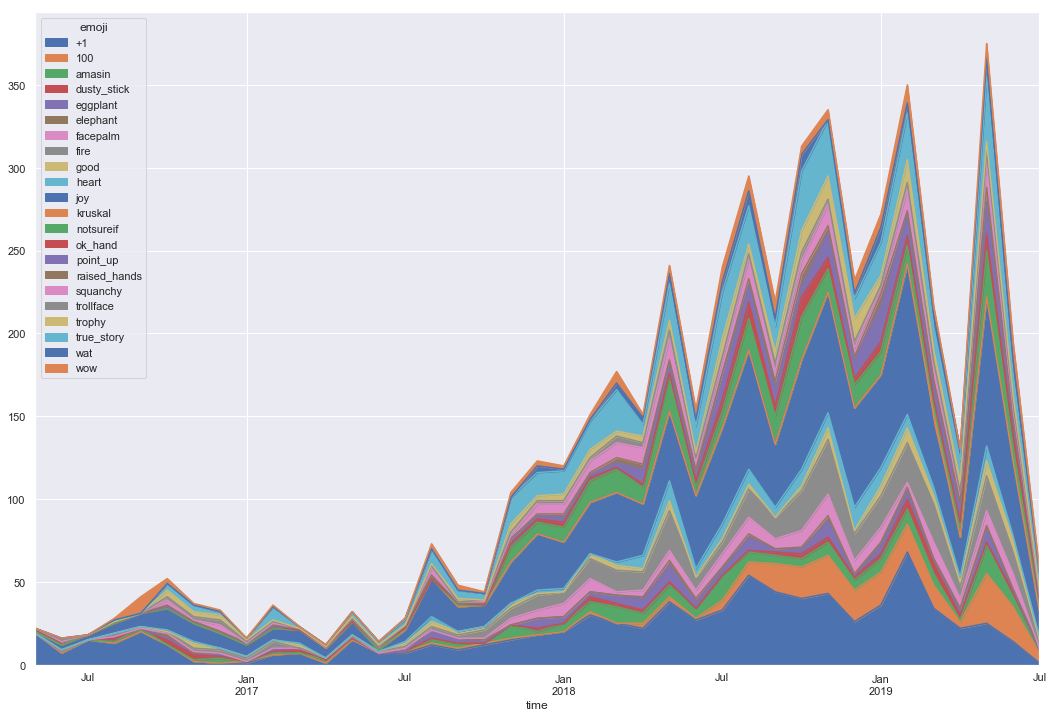

In [7]:
fig, ax = plt.subplots(figsize=(18, 12))
subset_emojis = long_data[long_data['emoji'].isin(filtered_emojis[:20] + ['kruskal', 'elephant'])]
subset_emojis.groupby([pd.Grouper(key='time', freq='M'), 'emoji']).count()['channel'].unstack().fillna(0).plot.area(ax=ax);

## Emoji varies by Slack channel

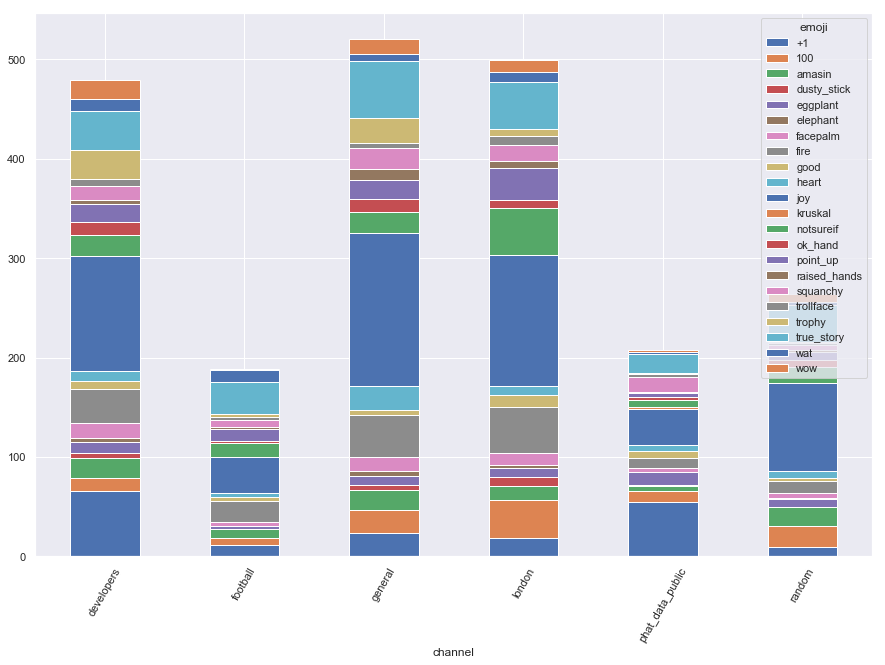

In [8]:
fig, ax = plt.subplots(figsize=(15, 10))
subset_emojis[subset_emojis['channel'].isin([
    'general', 'london', 'phat_data_public', 'phat_data_private'
    'zappi_client', 'random', 'developers', 'football'
])].groupby(['channel', 'emoji']).count()['type'].unstack().plot(kind='bar', stacked=True, ax=ax);

plt.xticks(rotation=60);

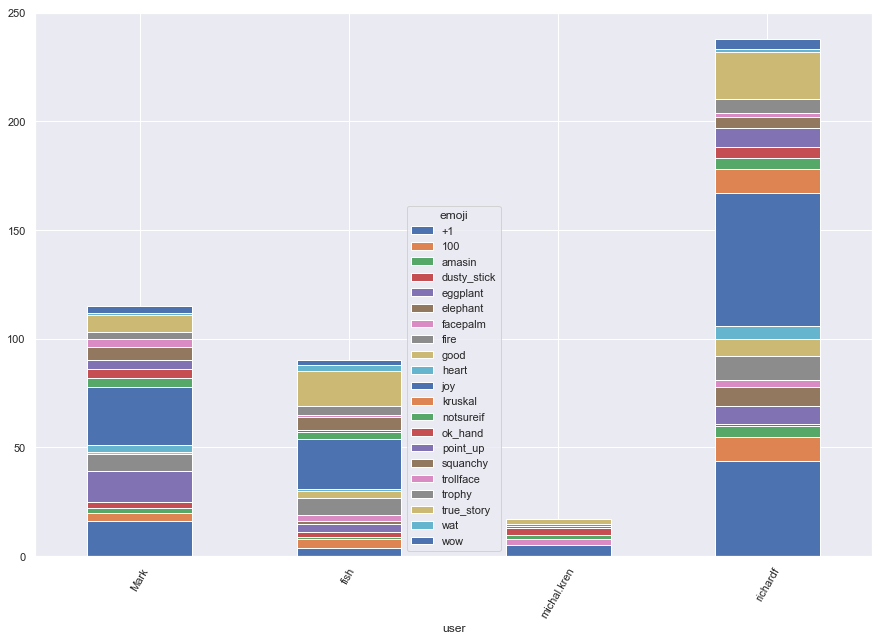

In [43]:
fig, ax = plt.subplots(figsize=(15, 10))
subset_emojis[subset_emojis['user'].isin([
    'fish', 'michal.kren', 'richardf', 'Mark'
])].groupby(['user', 'emoji']).count()['type'].unstack().plot(kind='bar', stacked=True, ax=ax);
plt.xticks(rotation=60);

In [ ]:
formatted_table = pd.get_dummies(df, columns = ['emoji']).groupby(['comment', 'time', 'channel', 'type', 'user'], sort=False, as_index=False).max()
print(formatted_table.shape)
formatted_table.head()

In [44]:
max_words = 10000

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df[df['tfidf'] > 0]

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

# TF IDF
vectorizer = TfidfVectorizer(max_features = max_words)
comment_vectors = vectorizer.fit_transform(formatted_table.comment.tolist())
features = vectorizer.get_feature_names()


row_id =1005
table_slice = formatted_table.iloc[row_id]

print(table_slice[['comment', 'channel', 'user']])
print('')
print(table_slice[table_slice == 1])
print('')
print(vectorizer.inverse_transform(comment_vectors[row_id]))
top_feats_in_doc(comment_vectors, features, row_id)

comment    you will never be alone with dan bot
channel                        phat_data_public
user                                      eze.h
Name: 1005, dtype: object

emoji_this_is_danb    1
Name: 1005, dtype: object

[array(['dan', 'you', 'will', 'be', 'never', 'with', 'bot', 'alone'],
      dtype='<U98')]


,feature,tfidf
0,alone,0.525715
1,bot,0.460074
2,dan,0.397100
3,never,0.375050
4,will,0.253019
5,with,0.245666
6,be,0.229320
7,you,0.191433


In [48]:
# Sentiment feature
sentiment = np.array(list(formatted_table.comment.apply(sentiment_transform).values))

# Channel feature
channel_encoder = LabelBinarizer()
one_hot_channels = channel_encoder.fit_transform(formatted_table['channel'].values.reshape(-1, 1))

# User feature
user_encoder = LabelBinarizer()
one_hot_users = user_encoder.fit_transform(formatted_table['user'].values.reshape(-1, 1))

In [49]:
# Concat features & split train/test
X = np.concatenate((comment_vectors.toarray(), sentiment, one_hot_channels, one_hot_users), axis=1)
y_cols = [i for i in formatted_table.columns if 'emoji' in i]
Y = formatted_table[y_cols]

print(X.shape, Y.shape)


Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.1, random_state=1000)
print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

(5693, 10341) (5693, 120)
(5123, 10341) (5123, 120)
(570, 10341) (570, 120)


In [50]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', df['emoji'].unique(), df['emoji'])

print(weights.shape)
weights

(120,)


array([4.33782051, 0.16833333, 0.51265152, 0.74199561, 4.33782051,
       1.70883838, 2.34965278, 2.08858025, 0.29067869, 0.59359649,
       2.25566667, 1.94454023, 1.08445513, 2.68531746, 0.25749619,
       1.31143411, 2.45181159, 0.34809671, 1.31143411, 1.17482639,
       0.41464461, 2.16891026, 2.16891026, 2.0139881 , 1.70883838,
       1.61119048, 1.87972222, 0.12312591, 1.02530303, 0.20506061,
       4.33782051, 4.33782051, 1.15085034, 0.38102477, 0.31155617,
       1.87972222, 2.96798246, 3.52447917, 0.07040158, 3.13287037,
       3.52447917, 3.52447917, 0.51735474, 2.16891026, 2.08858025,
       0.92445355, 0.34809671, 2.81958333, 1.94454023, 1.76223958,
       1.94454023, 0.95579096, 3.75944444, 4.02797619, 0.38890805,
       5.12651515, 3.75944444, 2.68531746, 2.34965278, 3.13287037,
       2.68531746, 2.34965278, 4.33782051, 4.33782051, 5.12651515,
       1.25314815, 4.69930556, 5.12651515, 1.48399123, 2.96798246,
       2.16891026, 3.52447917, 2.68531746, 2.25566667, 1.94454

In [78]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.metrics import categorical_accuracy

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(Xtrain.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(Ytrain.shape[1]))
model.add(Activation('sigmoid'))

print(model.summary())
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1, categorical_accuracy])

batch_size = 32
epochs = 25

history = model.fit(Xtrain, Ytrain, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(Xtest, Ytest),
                    class_weight=weights,
                    callbacks=[
#                         EarlyStopping(patience=3)
                    ]
                   )
score = model.evaluate(Xtest, Ytest, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[2])
print('Test F1', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               5295104   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               61560     
_________________________________________________________________
activation_2 (Activation)    (None, 120)               0         
Total params: 5,356,664
Trainable params: 5,356,664
Non-trainable params: 0
_________________________________________________________________
None
Train on 5123 samples, validate on 570 samples
Epoch 1/25
5123/5123 [==============================] - 12s 2ms/step - loss: 0.1475 - f1: 7.7997e-04 - categorical_accuracy: 0.1120 - val_loss: 0.0491 - val_f1: 0.0000e+00 - val_categorical_accuracy: 0.1947
Epoch

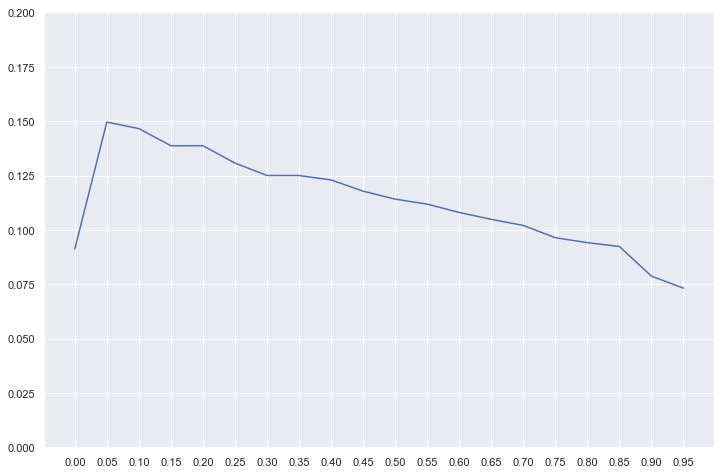

In [77]:
from sklearn.metrics import f1_score 

fig, ax = plt.subplots(1, figsize=(12, 8))

probs = model.predict_proba(Xtest) 
store = {}
for threshold in np.arange(0, 1, 0.05):
    classification = (probs > threshold).astype(int)
    store[threshold] = f1_score(Ytest, classification, average='weighted')

ax.plot(store.keys(), store.values())
ax.set_xticks(list(store.keys()));
ax.set_ylim(0, 0.2);

In [54]:

def process_pred(sentence, channel, user):
    return process_pred_specified_models(
        sentence,
        channel,
        user,
        model=model,
        vectorizer=vectorizer,
        channel_encoder=channel_encoder,
        user_encoder=user_encoder,
        y_cols=y_cols
    )
test_sentences = [
    'brexit makes me sad',
    'great job on getting autocoding out, you massive nerds',
    'on leave that week', 
    'production is down', 
    'just be better', 
    'work harder', 
    'rocket to production', 
    'thats just wrong',
    'windows over mac',
    'you are a bell end',
    "it's not unreasonable to have a w9am meeting",
    "My understanding from talking to different folks is the issue is due to the different text length",
    '@steven.perianen IBM is loving the new verbatim auto coding!',
    'heyhey @daniel.baark -> https://zigroup.atlassian.net/browse/SP-5320',
    "The new DS review time clashes with another meeting",
    "It's not like me to skip meals",
    "There has been a complaint about people using the putney office and keeping the door propped open. Can people make sure the door isn't kept open when it shouldn't be.",
    "Ahh we call them a Microsoft Product Team"
]

for i, sent in enumerate(test_sentences):
    print(sent, '->', process_pred(sent, 'phat_data_public', 'richardf'))

brexit makes me sad -> [('gb', 0.0512934)]
great job on getting autocoding out, you massive nerds -> [('squanchy', 0.3429018), ('eggplant', 0.89765024), ('aw_yeah', 0.951852)]
on leave that week -> [('100', 0.16597144)]
production is down -> []
just be better -> []
work harder -> [('heisemberg', 0.12590477), ('nail_care', 0.1401345), ('fire', 0.23190126), ('joy', 0.9141009)]
rocket to production -> [('eggplant', 0.16599774)]
thats just wrong -> [('joy', 0.54576457), ('true_story', 0.96999604)]
windows over mac -> []
you are a bell end -> [('+1', 0.12584338), ('joy', 0.20957583), ('bananadance', 0.34246552)]
it's not unreasonable to have a w9am meeting -> [('notsureif', 0.06352045)]
My understanding from talking to different folks is the issue is due to the different text length -> [('notsureif', 0.9992105)]
@steven.perianen IBM is loving the new verbatim auto coding! -> []
heyhey @daniel.baark -> https://zigroup.atlassian.net/browse/SP-5320 -> [('+1', 0.99999774)]
The new DS review tim

In [ ]:
xpred = vectorizer.transform([sentence])
new_x = np.concatenate(
    (
        xpred.toarray(),
        np.array([sentiment_transform(sentence)]),
        encoder_predict(channel_encoder, channel),
        encoder_predict(user_encoder, user)
    ), axis=1)
pred = model.predict(new_x)[0]

In [42]:
vec_file = "input_data/tfidf.pickle"
channel_file = "input_data/channel_enc.pickle"
user_file = "input_data/user_enc.pickle"
y_file = "input_data/y_cols.pickle"
model_file = "my_model.h5"
user_list_file = 'input_data/users.pkl'
channel_list_file = 'input_data/channel_info.pkl'

file_store = [
    vec_file, channel_file, user_file, y_file, model_file, 
    user_list_file, channel_list_file
]

In [4]:
# from os import getenv
# import boto3

# aws_id = getenv('DAN_BOT_AWS_ID')
# aws_key = getenv('DAN_BOT_AWS_KEY')
# aws_bucket = getenv('DAN_BOT_BUCKET')

# s3 = boto3.client('s3', aws_access_key_id=aws_id, aws_secret_access_key=aws_key)

# persist_data = False
# if persist_data:
#     pickle.dump(vectorizer, open(vec_file, "wb"))
#     pickle.dump(channel_encoder, open(channel_file, "wb"))
#     pickle.dump(user_encoder, open(user_file, "wb"))
#     pickle.dump(y_cols, open(y_file, "wb"))
#     model.save(model_file)

#     for file in file_store:
#         s3.upload_file(file, aws_bucket, file)

